# Semantic Segmentation of Building Functions in Satellite Images 

This script loads the training data, creates the model architecutre, and goes through training, and visualization of predictions. 

In [1]:
import os
import torch
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.optim import AdamW
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau
import matplotlib.pyplot as plt
from torch.cuda.amp import GradScaler, autocast
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import to_tensor
from sklearn.model_selection import train_test_split
import models.models as models
import random
from models.UNetSESkip import UNetSESkip
from models.UNetDilations import UNet
from models.ResidualUNet import ResnetUNet


c:\Users\Citylab\.conda\envs\torchenv2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.autograd.set_detect_anomaly(True)

# Load Data

Creating Data loaders for Training and Validation. Test split is 80-20

In [3]:
class CustomDataset(Dataset):
    def __init__(self, images_dir, masks_dir, files, image_transform=None, mask_transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.files = files
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.files[idx])
        mask_path = os.path.join(self.masks_dir, self.files[idx])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Load mask as grayscale

        if self.image_transform:
            image = self.image_transform(image)
        
        # Convert mask image to numpy array, then to tensor
        mask = np.array(mask, dtype=np.int32)  # Ensure the mask is an integer array
        mask = torch.from_numpy(mask)  # Convert numpy array to tensor

        return image, mask


# Image and mask transformations
image_transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Adjust brightness, contrast, and saturation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5281, 0.5468, 0.5364], std=[0.1913, 0.1705, 0.1566]) #Calculated mean: tensor([0.5281, 0.5468, 0.5364]) Calculated std: tensor([0.1913, 0.1705, 0.1566])
])
mask_transform = transforms.ToTensor()

# Set directories and prepare file lists
images_dir = 'Data/Processed/naip_tiles_128px250m'
masks_dir = 'Data/Processed/lu_tiles_128px250m'
files = [f for f in os.listdir(images_dir) if os.path.isfile(os.path.join(images_dir, f)) and not (f.endswith('(1).tif') or f.endswith('(2).tif'))]

# Split files into training and validation sets
train_files, val_files = train_test_split(files, test_size=0.30, random_state=42)
val_files,test_files = train_test_split(val_files, test_size=0.5, random_state=42)

# Dataset and DataLoader setup using paths
train_dataset = CustomDataset(images_dir, masks_dir, train_files, image_transform=image_transform, mask_transform=mask_transform)
val_dataset = CustomDataset(images_dir, masks_dir, val_files, image_transform=image_transform, mask_transform=mask_transform)
test_dataset = CustomDataset(images_dir, masks_dir, test_files, image_transform=image_transform, mask_transform=mask_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [4]:
# import torch
# from torchvision import transforms
# from torch.utils.data import DataLoader
# from PIL import Image
# import os
# import numpy as np

# def compute_mean_std(loader):
#     # Varible for the sum, sum of squares, and the number of samples
#     mean = 0.0
#     std = 0.0
#     nb_samples = 0.0
    
#     for data in loader:
#         images, _ = data
#         batch_samples = images.size(0)
#         images = images.view(batch_samples, images.size(1), -1)
#         mean += images.mean(2).sum(0)
#         std += images.std(2).sum(0)
#         nb_samples += batch_samples

#     mean /= nb_samples
#     std /= nb_samples
#     return mean, std

# # Setup for using the compute function, use a simple transform to convert images to tensor
# simple_transform = transforms.Compose([
#     transforms.Resize((128, 128)),
#     transforms.ToTensor(),
# ])

# # Assuming you have already defined your CustomDataset
# # Create a temporary dataset for mean/std computation
# temp_dataset = CustomDataset(images_dir, masks_dir, files, image_transform=simple_transform)
# temp_loader = DataLoader(temp_dataset, batch_size=10, shuffle=False)

# # Compute mean and standard deviation
# mean, std = compute_mean_std(temp_loader)
# print(f"Calculated mean: {mean}")
# print(f"Calculated std: {std}")


# Visualization of Training Data

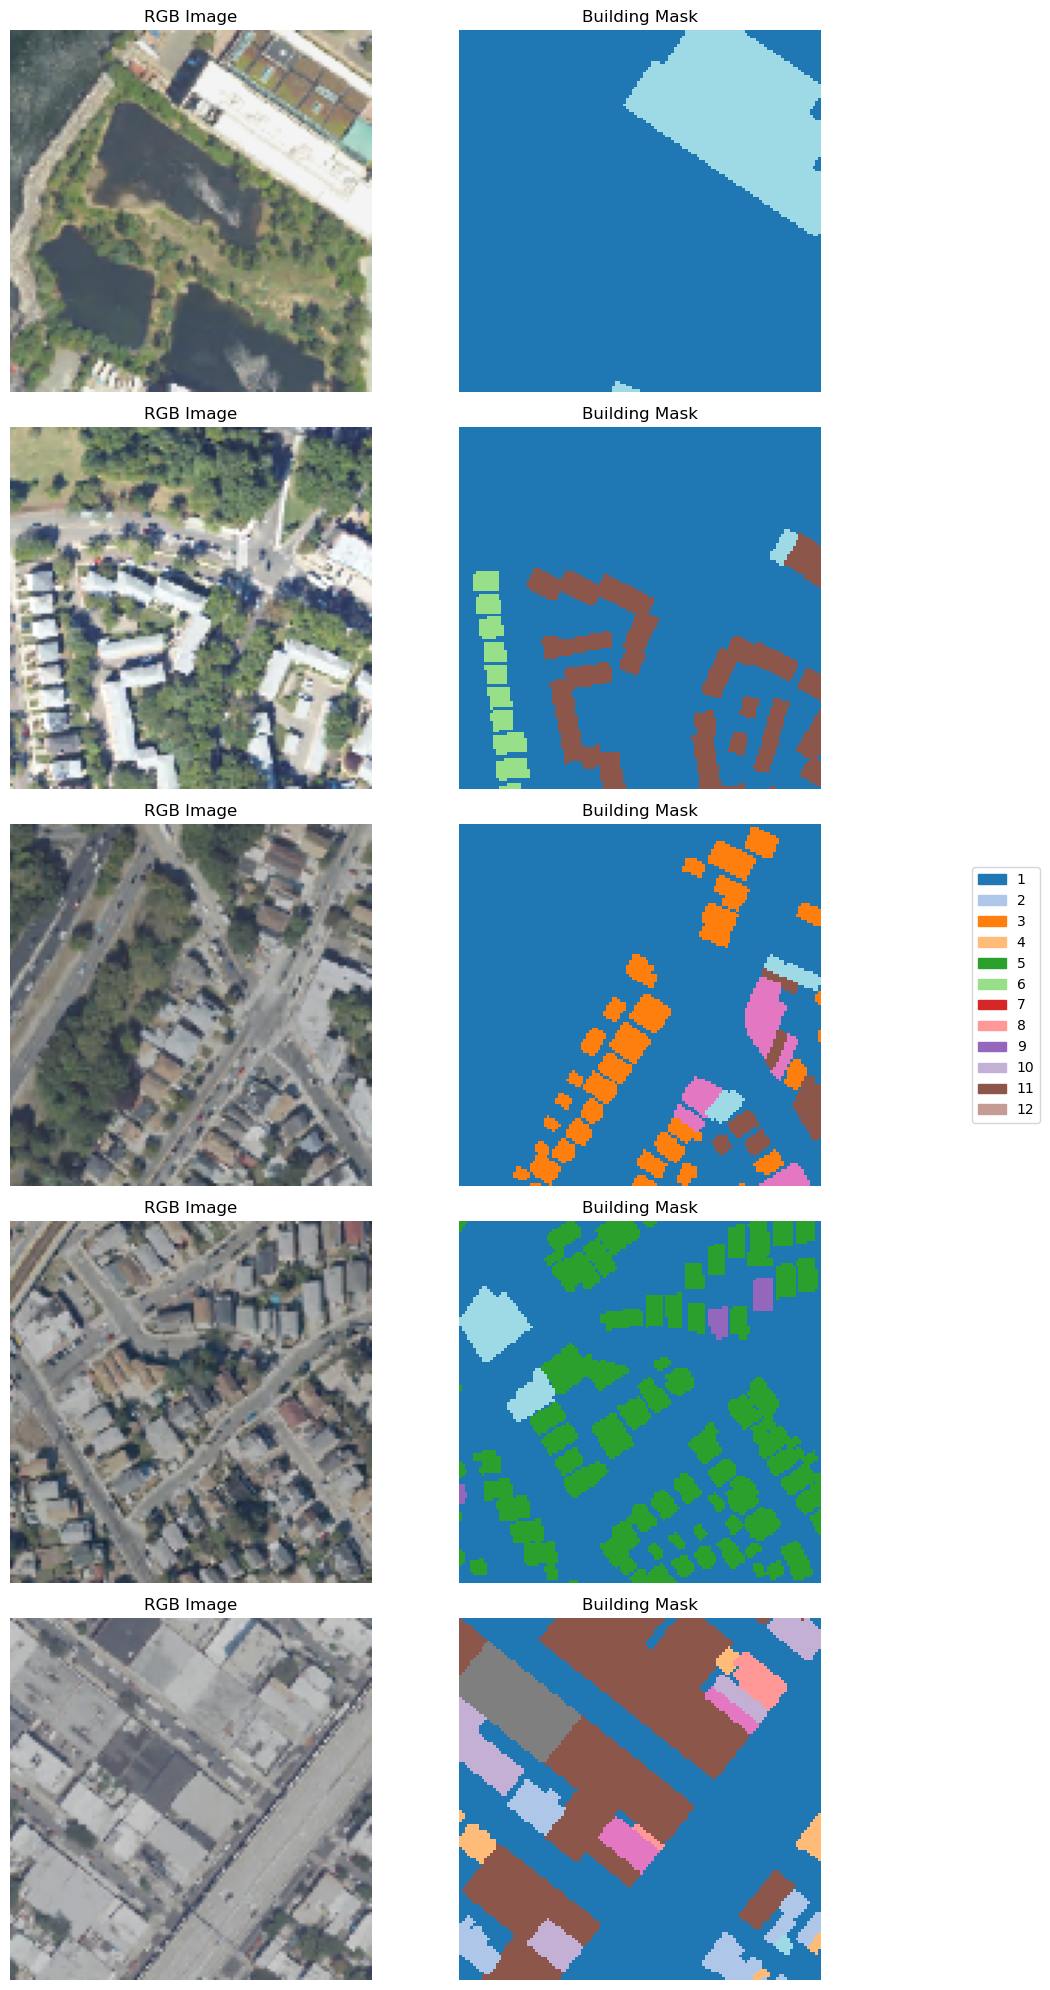

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def plot_images(images, masks, num_images=5, class_labels=None):
    # Define the colormap and create a patch (proxy artist) for every color 
    cmap = plt.get_cmap('tab20')
    colors = [cmap(i) for i in range(len(class_labels))]  # Assuming number of classes doesn't exceed the cmap length
    patches = [mpatches.Patch(color=colors[i], label=class_labels[i]) for i in range(len(class_labels))]

    fig, axs = plt.subplots(num_images, 2, figsize=(10, 20))
    for i in range(num_images):
        img = images[i].permute(1, 2, 0)  # Convert from CxHxW to HxWxC
        img = img * torch.tensor([0.1913, 0.1705, 0.1566], device=img.device).view(1, 1, 3) + torch.tensor([0.5281, 0.5468, 0.5364], device=img.device).view(1, 1, 3)
        img = img.detach().cpu().numpy()
        mask = masks[i].squeeze().detach().cpu().numpy()

        axs[i, 0].imshow(img.clip(0, 1))  # Clip the values to be in the valid range for imshow
        axs[i, 0].set_title('RGB Image')
        axs[i, 0].axis('off')

        # Display mask with nearest interpolation
        mask_display = axs[i, 1].imshow(mask, cmap='tab20', interpolation='nearest')
        axs[i, 1].set_title('Building Mask')
        axs[i, 1].axis('off')

    # Place a legend outside the rightmost column
    fig.legend(handles=patches, bbox_to_anchor=(1.05, 0.5), loc='center left')

    plt.tight_layout()
    plt.show()

# Class labels (example labels, adjust as necessary)
class_labels = range(1,13)

# Fetch images and masks
for images, masks in train_loader:
    plot_images(images, masks, num_images=5, class_labels=class_labels)
    break  # Only process the first batch


In [6]:
print('size training dataset: ',len(train_dataset))
print('size val dataset: ',len(val_dataset))
print('size test dataset: ',len(test_dataset))

size training dataset:  13520
size val dataset:  2897
size test dataset:  2898


In [7]:
# import torch
# from collections import defaultdict

# def count_labels(dataloader):
#     label_counts = defaultdict(int)
#     max_label = 0

#     for _, masks in dataloader:
#         for mask in masks:
#             unique_labels = torch.unique(mask)
#             for label in unique_labels:
#                 label_counts[int(label.item())] += 1
#                 if label.item() > max_label:
#                     max_label = label.item()

#     return label_counts, max_label

# # Calculate label counts and the maximum label in the training data
# train_label_counts, train_max_label = count_labels(train_loader)

# print("Label counts in training data:", train_label_counts)
# print("Maximum label in training data:", train_max_label+1)


# Model Architecture

U Net with Dilated Convolutions

In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Assuming `model` is an instance of your UNet
unet_model = UNet(n_channels=3, n_classes=12)  # Example: 3 input channels (RGB), 11 output classes
unet_modelSelfAtt = models.UNetSelfAtt(n_channels=3, n_classes=12)  # Example: 3 input channels (RGB), 11 output classes
unet_modelSE = models.UNetSE(n_channels=3, n_classes=12)
unet_modelSESkip = UNetSESkip(n_channels=3, n_classes=12)
unet_modelResidualUNet = ResnetUNet(n_channels=3, n_classes=12)


total_params = count_parameters(unet_model)
total_paramsSelfAtt = count_parameters(unet_modelSelfAtt)
total_paramsunet_modelSE = count_parameters(unet_modelSE)
total_paramsunet_modelSESkip = count_parameters(unet_modelSESkip)
total_paramsResidualUNet = count_parameters(unet_modelResidualUNet)

print(f"Total trainable parameters in U-Net model: {total_params}")
print(f"Total trainable parameters in U-NetSelfAtt model: {total_paramsSelfAtt}")
print(f"Total trainable parameters in U-unet_modelSE model: {total_paramsunet_modelSE}")
print(f"Total trainable parameters in U-unet_modelSESkip model: {total_paramsunet_modelSESkip}")
print(f"Total trainable parameters in unet_modelResidualUNet: {total_paramsResidualUNet}")


Total trainable parameters in U-Net model: 17268108
Total trainable parameters in U-NetSelfAtt model: 17317372
Total trainable parameters in U-unet_modelSE model: 17268620
Total trainable parameters in U-unet_modelSESkip model: 13407308
Total trainable parameters in unet_modelResidualUNet: 17797004


In [9]:
# def check_labels(dataloader):
#     unique_labels = set()
#     for _, masks in dataloader:
#         for mask in masks:
#             unique_labels.update(torch.unique(mask).tolist())

#     return unique_labels

# train_unique_labels = check_labels(train_loader)
# val_unique_labels = check_labels(val_loader)

# print("Unique labels in training data:", train_unique_labels)
# print("Unique labels in validation data:", val_unique_labels)

# IoU

In [10]:
def iou_score(output, target, num_classes=12):
    # output and target shapes are (batch_size, H, W) with class indices [0, num_classes-1]
    ious = []
    for cls in range(num_classes):  # Loop over each class
        output_cls = (output == cls)
        target_cls = (target == cls)
        
        intersection = (output_cls & target_cls).sum((1, 2)).float()  # Sum over height and width dimensions
        union = (output_cls | target_cls).sum((1, 2)).float()  # Sum over height and width dimensions
        
        # Avoid division by zero
        iou = (intersection + 1e-6) / (union + 1e-6)  # Small constant to avoid division by zero
        ious.append(iou.mean())  # Average over batch
    return torch.tensor(ious).mean()  # Average over all classes

# Training Setup 

In [11]:
# Model initialization
from torch.optim.lr_scheduler import CyclicLR

# model = UNet(n_channels=3, n_classes=12).to(device)  # Adjusted to include 12 classes
model = ResnetUNet(n_channels=3, n_classes=12).to(device)
criterion = nn.CrossEntropyLoss()  # Suitable for classification with multiple classes
# criterion = CombinedLoss(edge_weight=0.7, class_weight=1.0, num_classes=12, device=device)


base_lr = 1e-5
max_lr = 1e-3

optimizer = AdamW(model.parameters(), lr=base_lr, weight_decay=1e-03)
# scheduler = ExponentialLR(optimizer, gamma=0.9)
# scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=10, verbose=True)

# # Example parameters

step_size_up = 20  # Steps it takes to ramp from the base to the max learning rate
mode = 'triangular'  # Other modes include 'triangular2', 'exp_range'

scheduler = CyclicLR(optimizer, base_lr=base_lr, max_lr=max_lr, step_size_up=step_size_up, mode=mode, cycle_momentum=False)  # Important for AdamW compatibility)


# lr  = 5e-03
# min_lr = 5e-05
# total_epoch=35
# optimizer = AdamW(model.parameters(), lr= lr, weight_decay=1e-02)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_epoch, eta_min=min_lr)





In [12]:
print(model)

ResnetUNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (relu): ReLU(inplace=True)
    (match_dimensions): Sequential(
      (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affin

# Training Loop

In [13]:
import matplotlib.pyplot as plt
from torch.cuda.amp import GradScaler

num_epochs = 35
scaler = GradScaler()

train_losses = []
val_losses = []
val_accuracies = []  # List to store validation accuracies for each epoch
val_ious = []  # List to store IoU for each epoch
learning_rates = []  # List to track learning rate for each epoch
best_val_accuracy = 0  # Track the best validation accuracy for early stopping
best_val_iou = 0  # Track the best validation IoU for early stopping

def iou_score(output, target, num_classes=12):
    ious = []
    for cls in range(num_classes):
        output_cls = (output == cls)
        target_cls = (target == cls)

        intersection = (output_cls & target_cls).sum((1, 2)).float()
        union = (output_cls | target_cls).sum((1, 2)).float()

        iou = (intersection + 1e-6) / (union + 1e-6)
        ious.append(iou.mean())
    return torch.tensor(ious).mean()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total = 0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.squeeze(1).long()  # Ensure labels are Long type

        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        #back ward pass and optimization
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step() #update lR
        running_loss += loss.item() * inputs.size(0)
        total += inputs.size(0)
        
        # Reporting per iteration
        if (i + 1) % 10 == 0:
            print(f"Epoch {epoch+1}, {100. * (i + 1) / len(train_loader):.2f}% complete, Loss: {loss.item():.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")

    average_train_loss = running_loss / total
    train_losses.append(average_train_loss)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_total = 0
    correct_predictions = 0
    val_totalPix = 0.0
    all_preds= []
    all_labels=[]

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.squeeze(1).long()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * inputs.size(0)
            val_total += inputs.size(0)
            val_totalPix += labels.numel()
            correct_predictions += torch.sum(preds == labels).item()
            # Calculate IoU score
            all_preds.append(preds)
            all_labels.append(labels)
        all_preds = torch.cat(all_preds) #concatenate allpreds across all batches
        all_labels = torch.cat(all_labels)
        # Calculate IoU score
        iou = iou_score(preds, labels)

        val_epoch_loss = val_running_loss / val_total
        val_losses.append(val_epoch_loss)
        
        val_accuracy = correct_predictions / val_totalPix
        val_accuracies.append(val_accuracy)
        val_ious.append(iou.item())

        print(f"End of Epoch {epoch+1}, Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Validation IoU: {iou:.4f}")

        # Early stopping and model saving based on the best IoU
        if iou > best_val_iou:
            best_val_iou = iou  # Update the best IoU tracker
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"Model saved with IoU: {iou:.4f}")

        # Update the scheduler and track the learning rate

        # learning_rates.append(optimizer.param_groups[0]['lr'])
        learning_rates.append(scheduler.get_last_lr()[0])



Epoch 1, 4.72% complete, Loss: 1.6196, LR: 0.000505
Epoch 1, 9.43% complete, Loss: 1.1795, LR: 0.001000
Epoch 1, 14.15% complete, Loss: 1.0266, LR: 0.000505
Epoch 1, 18.87% complete, Loss: 0.9196, LR: 0.000010
Epoch 1, 23.58% complete, Loss: 0.9113, LR: 0.000505
Epoch 1, 28.30% complete, Loss: 0.9299, LR: 0.001000
Epoch 1, 33.02% complete, Loss: 0.8555, LR: 0.000505
Epoch 1, 37.74% complete, Loss: 0.7266, LR: 0.000010
Epoch 1, 42.45% complete, Loss: 0.7853, LR: 0.000505
Epoch 1, 47.17% complete, Loss: 0.6975, LR: 0.001000
Epoch 1, 51.89% complete, Loss: 0.8377, LR: 0.000505
Epoch 1, 56.60% complete, Loss: 0.7179, LR: 0.000010
Epoch 1, 61.32% complete, Loss: 0.6836, LR: 0.000505
Epoch 1, 66.04% complete, Loss: 0.7384, LR: 0.001000
Epoch 1, 70.75% complete, Loss: 0.6827, LR: 0.000505
Epoch 1, 75.47% complete, Loss: 0.6736, LR: 0.000010
Epoch 1, 80.19% complete, Loss: 0.8080, LR: 0.000505
Epoch 1, 84.91% complete, Loss: 0.8058, LR: 0.001000
Epoch 1, 89.62% complete, Loss: 0.7315, LR: 0.00

In [14]:
# save end-of-epochs model as well
torch.save(model.state_dict(), 'model-allEpochs.pth')


In [15]:
# import matplotlib.pyplot as plt
# from torch.cuda.amp import GradScaler

# num_epochs = 35
# scaler = GradScaler()

# train_losses = []
# val_losses = []
# val_accuracies = []  # List to store validation accuracies for each epoch
# val_ious = []  # List to store IoU for each epoch
# learning_rates = []  # List to track learning rate for each epoch
# best_val_accuracy = 0  # Track the best validation accuracy for early stopping
# best_val_iou = 0  # Track the best validation IoU for early stopping

# def iou_score(output, target, num_classes=12):
#     ious = []
#     for cls in range(num_classes):
#         output_cls = (output == cls)
#         target_cls = (target == cls)

#         intersection = (output_cls & target_cls).sum((1, 2)).float()
#         union = (output_cls | target_cls).sum((1, 2)).float()

#         iou = (intersection + 1e-6) / (union + 1e-6)
#         ious.append(iou.mean())
#     return torch.tensor(ious).mean()
# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0
#     total = 0

#     for i, (inputs, labels) in enumerate(train_loader):
#         inputs, labels = inputs.to(device), labels.to(device)
#         labels = labels.squeeze(1).long()  # Ensure labels are Long type

#         optimizer.zero_grad()

#         # Forward pass
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)

#         # Backward pass and optimization
#         scaler.scale(loss).backward()

#         # Apply gradient clipping just before optimizer step
#         scaler.unscale_(optimizer)  # unscale the gradients of optimizer's assigned params in-place
#         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # max_norm is the maximum norm value

#         scaler.step(optimizer)
#         scaler.update()

#         # Update the scheduler after each batch
#         scheduler.step()

#         running_loss += loss.item() * inputs.size(0)
#         total += inputs.size(0)
        
#         # Reporting per iteration
#         if (i + 1) % 5 == 0:
#             print(f"Epoch {epoch+1}, {100. * (i + 1) / len(train_loader):.2f}% complete, Loss: {loss.item():.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")

#     average_train_loss = running_loss / total
#     train_losses.append(average_train_loss)

#     # Validation phase
#     model.eval()
#     val_running_loss = 0.0
#     val_total = 0
#     correct_predictions = 0
#     val_totalPix = 0.0
#     all_preds = []
#     all_labels = []

#     with torch.no_grad():
#         for inputs, labels in val_loader:
#             inputs, labels = inputs.to(device), labels.to(device)
#             labels = labels.squeeze(1).long()

#             outputs = model(inputs)
#             _, preds = torch.max(outputs, 1)
#             loss = criterion(outputs, labels)

#             val_running_loss += loss.item() * inputs.size(0)
#             val_total += inputs.size(0)
#             val_totalPix += labels.numel()
#             correct_predictions += torch.sum(preds == labels).item()

#             all_preds.append(preds)
#             all_labels.append(labels)

#         all_preds = torch.cat(all_preds)  # concatenate all predictions across all batches
#         all_labels = torch.cat(all_labels)  # concatenate all labels across all batches
#         iou = iou_score(all_preds, all_labels)

#         val_epoch_loss = val_running_loss / val_total
#         val_losses.append(val_epoch_loss)
        
#         val_accuracy = correct_predictions / val_totalPix
#         val_accuracies.append(val_accuracy)
#         val_ious.append(iou.item())

#         print(f"End of Epoch {epoch+1}, Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Validation IoU: {iou:.4f}")

#         # Early stopping and model saving based on the best IoU
#         if iou > best_val_iou:
#             best_val_iou = iou
#             torch.save(model.state_dict(), 'best_model.pth')
#             print(f"Model saved with IoU: {iou:.4f}")

#     # Track the learning rate at the end of each epoch
#     learning_rates.append(scheduler.get_last_lr()[0])



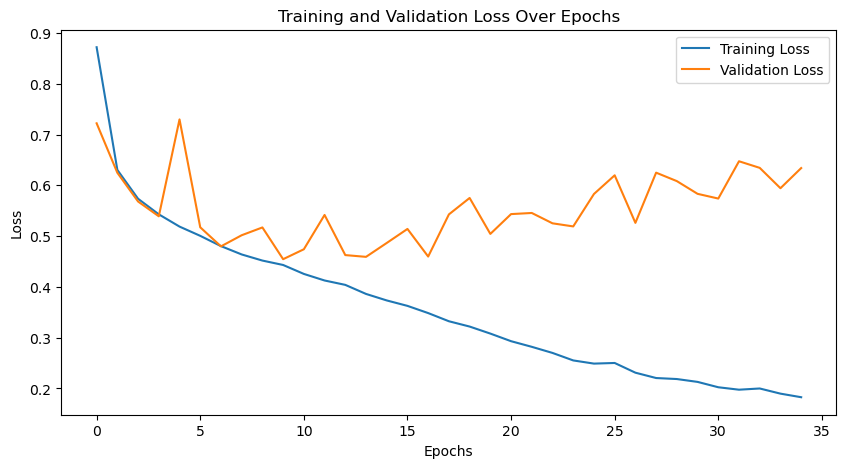

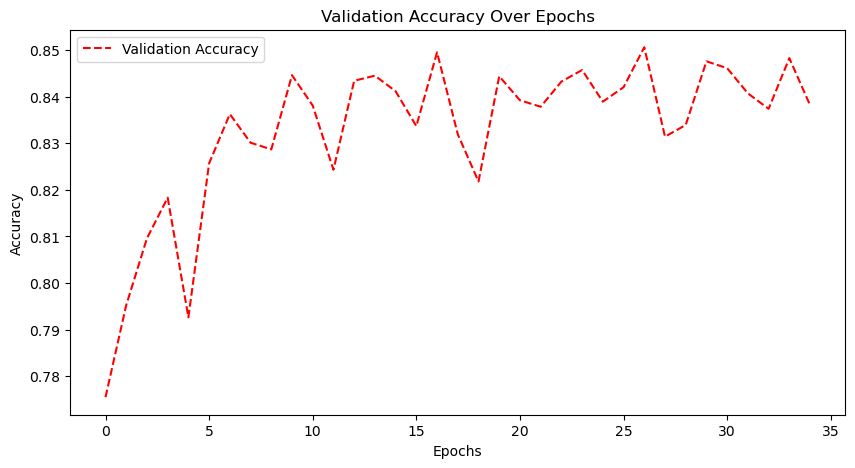

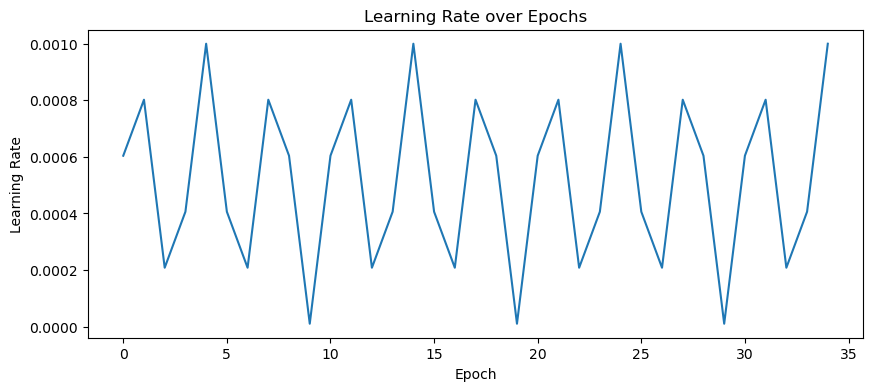

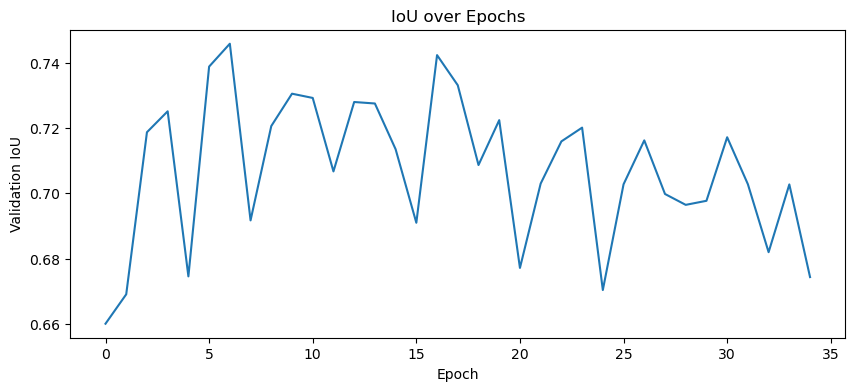

In [16]:
# Plotting the Training and Validation Losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
# plt.xticks(range(num_epochs))  # Set x-ticks to be integer
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# Plotting Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Validation Accuracy', linestyle='--', color='r')
# plt.xticks(range(num_epochs))  # Set x-ticks to be integer
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

# Plotting the learning rate
plt.figure(figsize=(10, 4))
plt.plot( learning_rates)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate over Epochs')
# plt.grid(True)
plt.show()

# Plotting the learning rate
plt.figure(figsize=(10, 4))
plt.plot( val_ious)
plt.xlabel('Epoch')
plt.ylabel('Validation IoU')
plt.title('IoU over Epochs')
# plt.grid(True)
plt.show()



# Plotting Validation Results 

Model Accuracy on Test Set: 0.8363
Mean Iou on Test Set: 0.6959


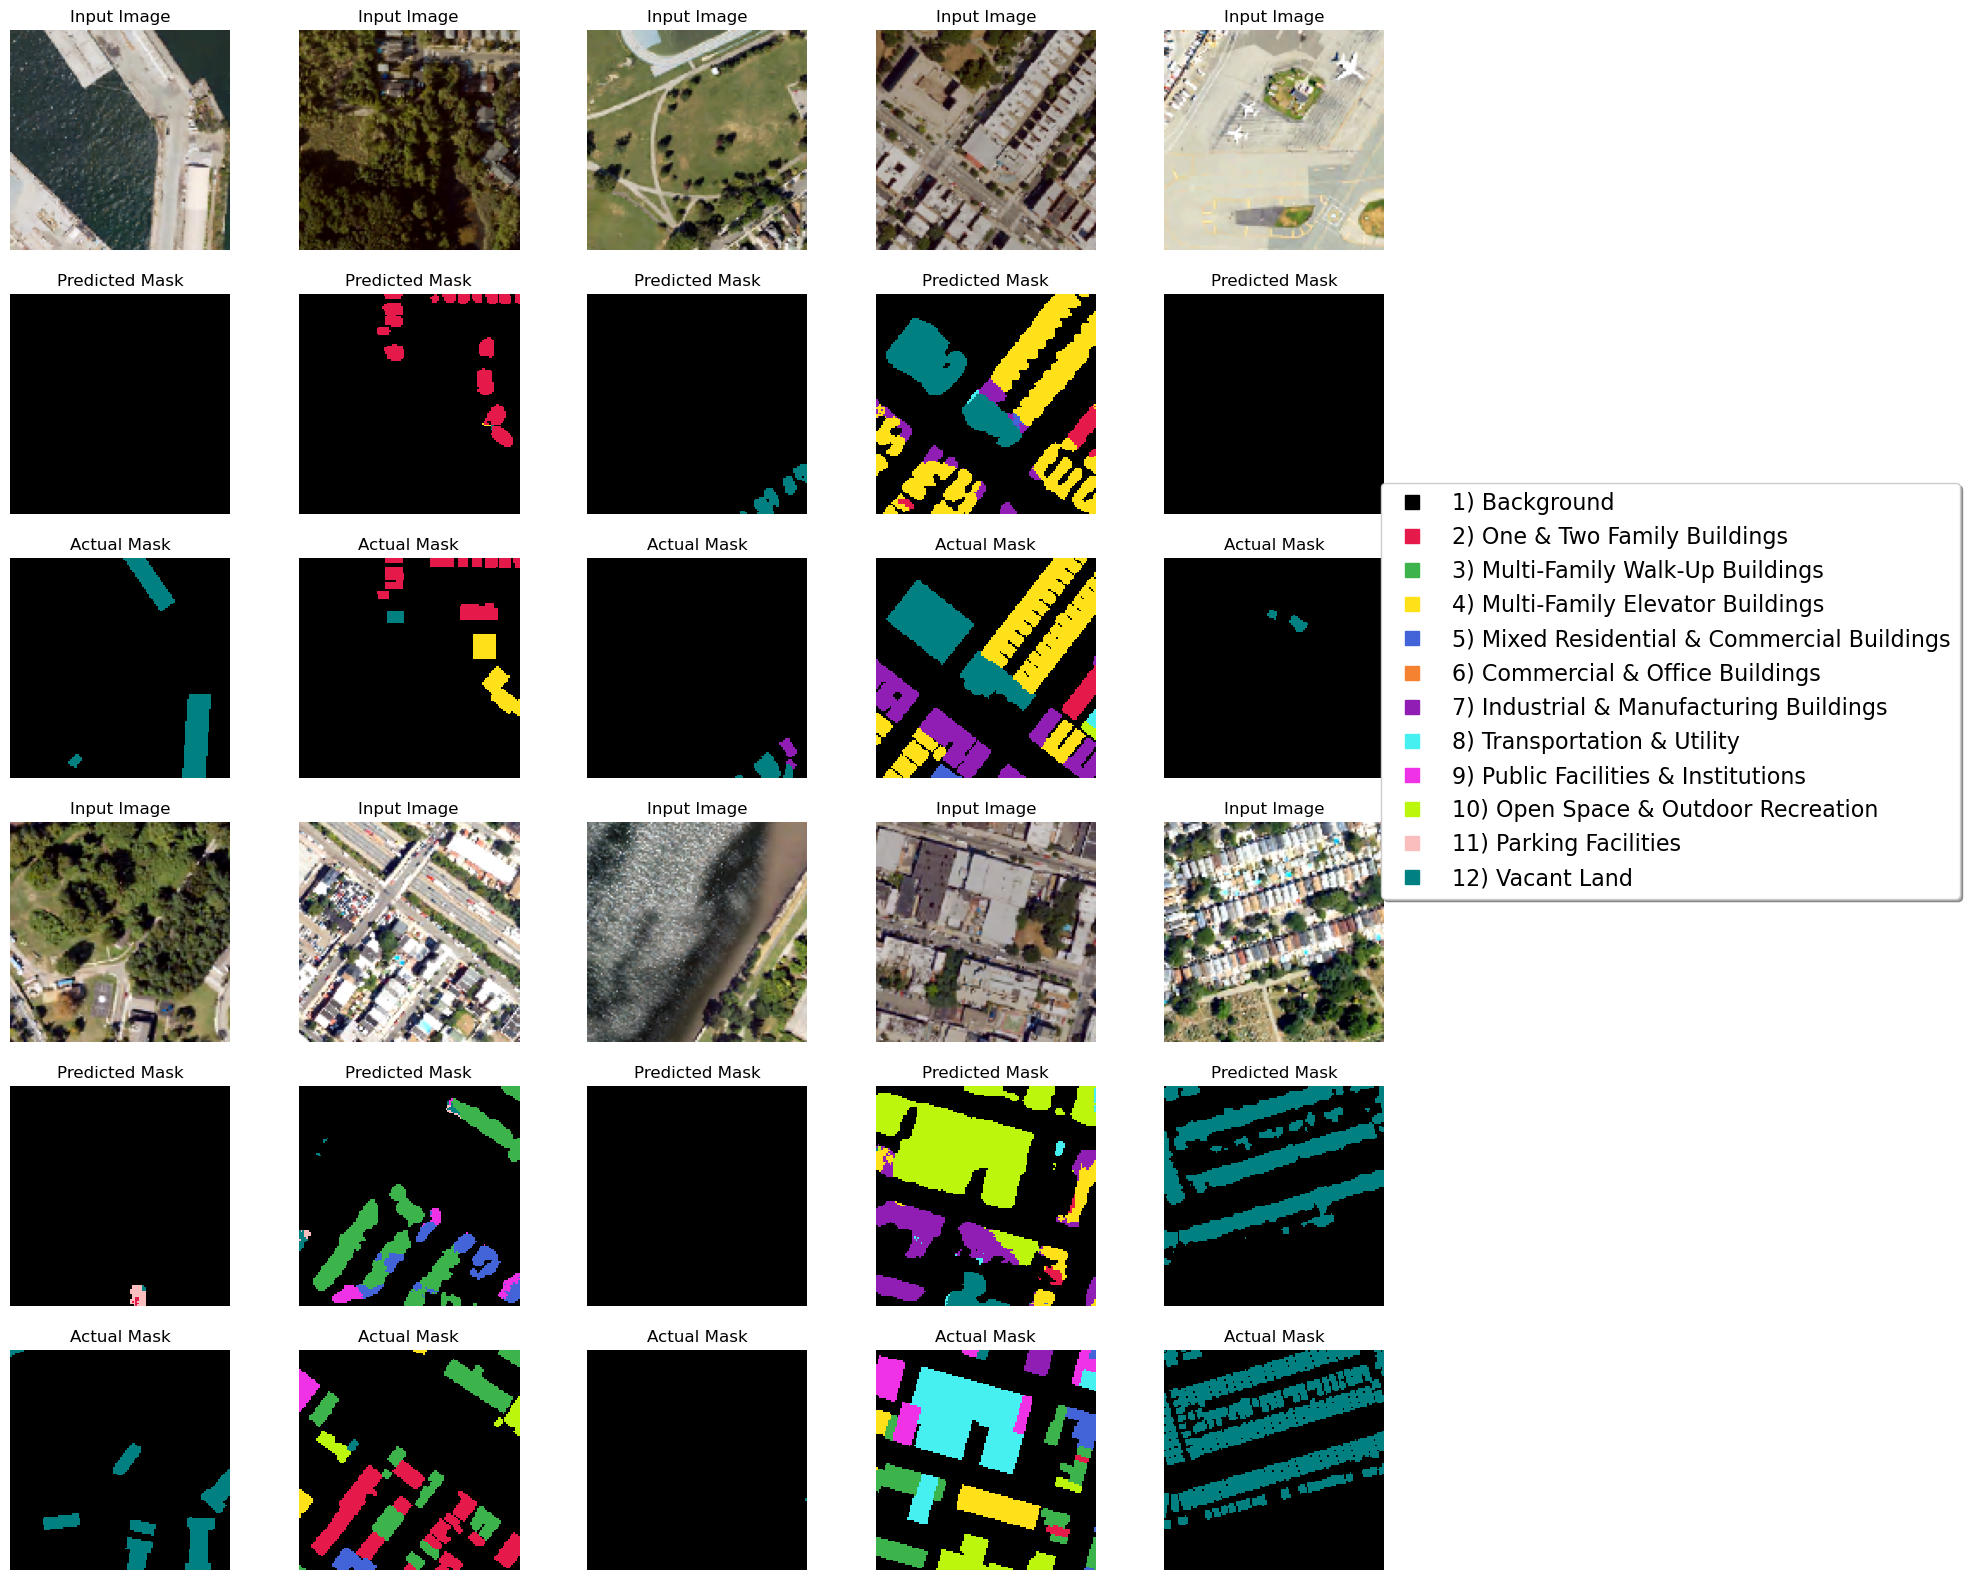

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from matplotlib.colors import ListedColormap

# Load the saved model weights
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)

test_loader = val_loader  # Using the validation loader for testing

def visualize_random_images(model, device, test_loader, num_visualizations=5):
    model.eval()
    images_to_visualize = []
    running_corrects = 0
    total_pixels = 0
    all_preds = []
    all_labels = []

    # Define a custom color map with distinct colors
    colors = ['#000000', '#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080']
    cmap = ListedColormap(colors)

    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)

            # Forward pass
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            # Calculate accuracy
            running_corrects += torch.sum(preds == masks)
            total_pixels += masks.numel()

            all_preds.append(preds)
            all_labels.append(masks)

            # Collect images and predictions
            if len(images_to_visualize) < num_visualizations * 2:  # Collect double the amount for 6 rows of unique images
                images_to_visualize.extend([(images[i].cpu(), preds[i].cpu(), masks[i].cpu()) for i in range(images.size(0))])

    # Calculate and print overall accuracy
    all_preds=torch.cat(all_preds)
    all_labels=torch.cat(all_labels)

    accuracy = running_corrects.double() / total_pixels
    mean_iou=iou_score(all_preds, all_labels)

    print(f"Model Accuracy on Test Set: {accuracy:.4f}")
    print(f"Mean Iou on Test Set: {mean_iou:.4f}")

    # Shuffle to get random images
    np.random.shuffle(images_to_visualize)
    images_to_visualize = images_to_visualize[:num_visualizations * 2]

    # Plotting
    plt.figure(figsize=(18, 20))  # Adjusted figure size
    rows_per_set = 6  # Six rows for two sets of images
    cols = num_visualizations  # Number of image sets

    for idx, (img, pred, actual) in enumerate(images_to_visualize):
        set_index = idx // num_visualizations
        col_position = idx % num_visualizations
        # Input Image
        plt.subplot(rows_per_set, cols, set_index * 3 * cols + col_position + 1)
        img_display = img.permute(1, 2, 0)
        img_display = img_display * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
        img_display = img_display.clip(0, 1)
        plt.imshow(img_display)
        plt.title("Input Image")
        plt.axis("off")

        # Predicted Mask
        plt.subplot(rows_per_set, cols, (set_index * 3 + 1) * cols + col_position + 1)
        plt.imshow(pred.numpy(), cmap=cmap,interpolation='nearest')
        plt.title("Predicted Mask")
        plt.axis("off")

        # Actual Mask
        plt.subplot(rows_per_set, cols, (set_index * 3 + 2) * cols + col_position + 1)
        plt.imshow(actual.numpy(), cmap=cmap,interpolation='nearest')
        plt.title("Actual Mask")
        plt.axis("off")

    # Create a legend for the classes
    class_labels = ["1) Background", "2) One & Two Family Buildings", "3) Multi-Family Walk-Up Buildings", "4) Multi-Family Elevator Buildings", "5) Mixed Residential & Commercial Buildings", "6) Commercial & Office Buildings", "7) Industrial & Manufacturing Buildings", "8) Transportation & Utility", "9) Public Facilities & Institutions", "10) Open Space & Outdoor Recreation", "11) Parking Facilities", "12) Vacant Land"]
    patches = [plt.plot([], [], marker="s", ms=10, ls="", mec=None, color=colors[i], label="{:s}".format(class_labels[i]))[0] for i in range(len(class_labels))]
    plt.legend(handles=patches, loc='lower center', bbox_to_anchor=(2.3, 3), fancybox=True, shadow=True, ncol=1,fontsize=16)

    # plt.tight_layout()
    plt.show()

# Call the visualization function
visualize_random_images(model, device, test_loader)


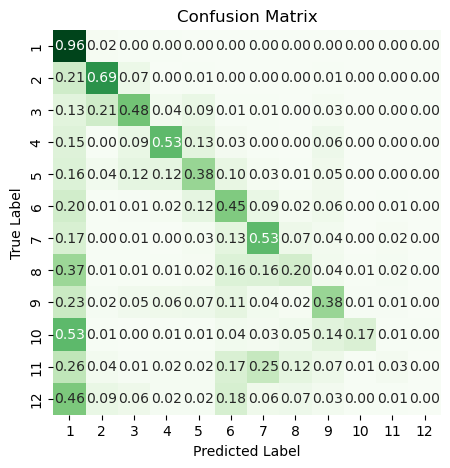

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(all_preds, all_labels, class_labels):
    # Convert predictions and labels from tensors to numpy arrays if not already done
    all_preds = all_preds.cpu().numpy()
    all_labels = all_labels.cpu().numpy()

    # Compute the confusion matrix
    cm = confusion_matrix(all_labels.flatten(), all_preds.flatten(), labels=np.arange(len(class_labels)))

    # Normalize the confusion matrix by row (i.e., by the number of samples in each class)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(5, 5))

    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Greens', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Ensure all_preds and all_labels are single concatenated tensors from the earlier validation code
# Call the function to plot the confusion matrix
plot_confusion_matrix(all_preds, all_labels, class_labels)
